<a href="https://colab.research.google.com/github/samlan2000/GEO885/blob/main/GEO885.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GEO885 - Detecting unusual time gaps in AIS data in the Brest Maritime Area

## Data

The AIS data used in this study was sourced from the “Heterogeneous Inte-grated Dataset for Maritime Intelligence, Surveillance, and Reconnaissance.” This dataset provides high quality AIS data along with auxiliary data such as fishing areas and the receiver theoretical coverage in the Brest region in northern France. The spans a six-month timeframe from 01-10-2015 to 31-03-2016 in the Brest maritime area, covering a region known for shell fishing activity. Additionally, port polygons were obtained from the French open government data platform.

https://www.data.gouv.fr/fr/datasets/limites-administratives-des-ports-du-finistere/ (last accessed: 6-10-2025) <br>

https://zenodo.org/records/1167595 (last accessed: 6-10-2025)




In [1]:
#mount drive to import data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#install packages
!pip install movingpandas
!pip install mapclassify
!pip install contextily
!pip install matplotlib-scalebar
!pip install matplotlib_map_utils

In [3]:
#import libraries
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import folium
from folium.plugins import HeatMap
import mapclassify
import math
from shapely.geometry import Point
import contextily as ctx
from pyproj import CRS
from shapely.ops import unary_union
from matplotlib_map_utils import ScaleBar, scale_bar
from matplotlib_map_utils.core.north_arrow import NorthArrow, north_arrow
from tqdm import tqdm
from datetime import timedelta
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from datetime import datetime
from folium.plugins import FloatImage
import os
import gc
import psutil
from scipy.stats import gaussian_kde

/usr/local/lib/python3.11/dist-packages/movingpandas/__init__.py:41: UserWarning: Missing optional dependencies. To use the trajectory smoother classes please install Stone Soup (see https://stonesoup.readthedocs.io/en/latest/#installation).
  warnings.warn(e.msg, UserWarning)


## Modes
This script can be run in three different modes. The **"analyze"** mode runs the script with the full data without plotting or saving the static maps and complimentary tables. However, it provides all other outputs such as the heatmap, temporal distribution graphs. It also enables the interactive mapping option. <br>
The **"show"** mode runs the script using a pre-defined range of data. It plots the maps and complimentary tables straight to the notebook. Note that naturally not all 387 maps can be shown in a single output (figure limit). <br>
The **"save"** mode saves the maps and tables to a google drive folder and uses batchwise processing. When memory overflow is an issue despite batchwise processing, the session can simply be restarted, rerunning the script. The script keeps track of which maps have already been produced and the general state of processing is stored in a .txt file.

In [4]:
valid_modes = ["analyze", "show", "save"]

mode = input("Select a mode (analyze/show/save): ").strip().lower()

while mode not in valid_modes:
    print("Invalid mode. Please choose from: analyze, show, or save.")
    mode = input("Select a mode (analyze/show/save): ").strip().lower()

print(f"Mode selected: {mode}")

Select a mode (analyze/show/save): analyze
Mode selected: analyze


## Color options

In [5]:
#ask the user if they want color-blind-friendly colors
use_cb_friendly = input("Use color-blind-friendly colors? (yes/no): ").strip().lower()

#set colors based on the user's choice
if use_cb_friendly == 'yes':
    color_support = "#0072B2"   # blue (color-blind friendly)
    color_incident = "#E69F00"  # orange (color-blind friendly)
else:
    color_support = "green"
    color_incident = "red"

Use color-blind-friendly colors? (yes/no): no


## Paths

If you want to run the script yourself and have downloaded the necessary data you only need to adjust the paths below. We also added the port polygons to the AIS dataset "[C1] Ports of Brittany" folder. <br>
- basepath refers to where the AIS dataset is stored <br>
- drive_path refers to a folder on Google Drive where the maps/tables should be stored

In [6]:
#define basepath
basepath = r"/content/drive/MyDrive/shared/"
#map/table storage
drive_path = r'/content/drive/MyDrive/vessel_outputs'
#check that saving folder exists
os.makedirs(drive_path, exist_ok=True)

# samuel: /content/drive/MyDrive/shared/AIS Data/[P1] AIS Data/nari_dynamic.csv
# raul: /content/drive/MyDrive/AIS Data/[P1] AIS Data/nari_dynamic.csv

#read AIS data
df = pd.read_csv(basepath + r"AIS Data/[P1] AIS Data/nari_dynamic.csv", sep=",")

#sort
df = df.sort_values(by=['sourcemmsi', 't'])

original_length = len(df)
print(original_length)

#head
print(df.head())

19035630
          sourcemmsi  navigationalstatus  rateofturn  speedoverground  \
15832248      923166                 0.0         0.0              9.1   
15832330      923166                 0.0      -126.0             10.8   
15835712      923166                 0.0       127.0              8.9   
15085665     1234500                 8.0      -127.0              0.0   
18982945     9105765                 NaN         NaN              0.2   

          courseoverground  trueheading       lon        lat           t  
15832248             256.9          256 -4.145470  50.339893  1448977129  
15832330             227.6          225 -4.166038  50.334972  1448977419  
15835712              84.2           91 -4.161366  50.336380  1448991801  
15085665             305.7          511 -4.173160  47.833645  1444808008  
18982945             253.1          253 -4.337853  48.091164  1458575300  


In [7]:
#convert to datetime
df['t'] = pd.to_datetime(df['t'], unit="s")

## Buffering and clipping

In [8]:
def buffer_ports(ports, base_buffersize=700):

    #calculate area and derive individual buffer sizes (e.g., sqrt(area) * scale factor)
    scale_factor = base_buffersize / 1000  # adjust as needed
    buffer_sizes = ports.geometry.area.apply(lambda a: (a ** 0.5) * scale_factor)

    #apply individual buffer sizes
    buffered_geometries = ports.geometry.buffer(buffer_sizes)

    return buffered_geometries

#read theoretical coverage (shapefile)
tc = gpd.read_file(basepath + r"AIS Data/[P1] Brest Receiver/Theoretical Coverage.shp")
#read the ports
ports = gpd.read_file(basepath + r"AIS Data/[C1] Ports of Brittany/DEP_MAR_LimitesAdminPorts/DEP_MAR_LimitesAdminPorts.shp")

#convert table point data to geodataframe (gdf)
df = gpd.GeoDataFrame(df, crs='epsg:4326', geometry=gpd.points_from_xy(df.lon, df.lat))

#clip points to theoretical coverage
print(f"before clipping for coverage: {len(df)}")
df = gpd.clip(df, tc)
print(f"after clipping for coverage: {len(df)}")

#compute buffer
ports_buffer = buffer_ports(ports)
#convert buffer to GeoDataFrame
ports_buffer_gdf = gpd.GeoDataFrame(geometry=ports_buffer)
#reproject buffer back to WGS84 (EPSG:4326)
ports_buffer_gdf = ports_buffer_gdf.to_crs(epsg=4326)
ports_buffer_gdf = gpd.clip(ports_buffer_gdf, tc)
ports_union = ports_buffer_gdf.union_all()

before clipping for coverage: 19035630
after clipping for coverage: 16155588


In [9]:
#sort full DataFrame
df = df.sort_values(by=['sourcemmsi', 't']).reset_index(drop=True)

## Modes data selection

In [10]:
#group by 'sourcemmsi' and count points
mmsi_counts = df['sourcemmsi'].value_counts()

#find the maximum - batch size needs to be larger!
max_points = mmsi_counts.max()
max_mmsi = mmsi_counts.idxmax()

print(f"Maximum number of points for a single MMSI: {max_points}")
print(f"MMSI with the most points: {max_mmsi}")

if mode == "show":
    start = input("We cannot plot all vessel maps (output limit). Select the starting index: ")
    end = input("It is not advised to not select a range > 10^6. Select the ending index: ")
    df = df[int(start):int(end)]

if mode == "save":
    # Load last cutoff (or set to 0)
    try:
        with open(f"{drive_path}/cutoff.txt", "r") as f:
            start_idx = int(f.read())
    except FileNotFoundError:
        start_idx = 0

    with open(f"{drive_path}/cutoff_old.txt", "w") as f:
        f.write(str(start_idx))

    print(f"Current starting index: {start_idx}")

    #define batch size
    batch_size = 2_000_000

    #slice up to batch size
    df_batch = df[start_idx : start_idx + batch_size]

    #ensure you don't cut off a vessel
    last_mmsi = df_batch['sourcemmsi'].iloc[-1]
    df_batch = df_batch[df_batch['sourcemmsi'] != last_mmsi]

    #calculate next cutoff
    next_cutoff = start_idx + len(df_batch)
    print(f"Current cutoff/next starting index: {next_cutoff}")

    df = df_batch

Maximum number of points for a single MMSI: 1167633
MMSI with the most points: 228186700


## Timedelta

The timedelta function searches for gaps larger than 30 minutes that are unlikely to arise due to technical issues. It also makes sure that the pair-wise structure is retained.

In [11]:
def filter_timedelta(df, max_timediff=30):
    """
    Args:
    :df: dataframe to be filtered
    :max_timediff: maximum time difference in minutes

    :return: filtered DataFrame
    """

    df = df.copy()

    #ensure datetime dtype
    df['t'] = pd.to_datetime(df['t'])

    #sort for correct time difference
    df = df.sort_values(['sourcemmsi', 't'])

    #compute time differences within each MMSI group
    df['t_diff'] = df.groupby('sourcemmsi')['t'].diff()

    #filter suspicious time gaps (either before or after a gap >= max_timediff)
    suspicious_mask = (
        (df['t_diff'] >= pd.Timedelta(minutes=max_timediff)) |
        (df.groupby('sourcemmsi')['t_diff'].shift(-1) >= pd.Timedelta(minutes=max_timediff))
    )
    filtered_df = df[suspicious_mask].reset_index(drop=True)

    #ensure pairwise structure
    extended_rows = []
    for mmsi, group in filtered_df.groupby('sourcemmsi'):
        for i in range(len(group)):
            extended_rows.append(group.iloc[i])
            if (
                i < len(group) - 1
                and group.iloc[i]['t_diff'] >= pd.Timedelta(minutes=max_timediff)
                and group.iloc[i + 1]['t_diff'] >= pd.Timedelta(minutes=max_timediff)
            ):
                extended_rows.append(group.iloc[i].copy())

    filtered_df = pd.DataFrame(extended_rows).reset_index(drop=True)
    #add label "support" if index even, else label "incident"
    filtered_df['label'] = filtered_df.index.to_series().apply(lambda x: 'support' if x % 2 == 0 else 'incident')

    #convert to GeoDataFrame
    filtered_df = gpd.GeoDataFrame(
        filtered_df,
        crs='epsg:4326',
        geometry=gpd.points_from_xy(filtered_df.lon, filtered_df.lat)
    )

    return filtered_df

filtered_df_time = filter_timedelta(df)

In [12]:
filtered_df_time

,sourcemmsi,navigationalstatus,rateofturn,speedoverground,courseoverground,trueheading,lon,lat,t,geometry,t_diff,label
0,37100300,0.0,-127.0,5.8,87.4,511,-4.640342,48.121000,2015-10-06 22:52:05,POINT (-4.64034 48.121),NaT,support
1,37100300,0.0,-127.0,7.1,25.8,511,-4.490952,48.172207,2015-10-06 23:59:43,POINT (-4.49095 48.17221),0 days 01:07:38,incident
2,37100300,1.0,-127.0,0.0,0.0,511,-4.475267,48.218647,2015-10-07 17:53:45,POINT (-4.47527 48.21865),0 days 00:06:01,support
3,37100300,1.0,-127.0,0.0,0.0,511,-4.475267,48.218647,2015-10-07 18:38:44,POINT (-4.47527 48.21865),0 days 00:44:59,incident
4,37100300,1.0,-127.0,0.0,0.0,511,-4.475267,48.218647,2015-10-08 02:53:51,POINT (-4.47527 48.21865),0 days 00:06:01,support
...,...,...,...,...,...,...,...,...,...,...,...,...
55059,999999999,0.0,-127.0,17.3,346.0,511,-4.724483,47.944828,2016-02-22 10:17:24,POINT (-4.72448 47.94483),17 days 21:58:51,incident
55060,999999999,0.0,-127.0,15.4,331.5,511,-4.783122,48.318120,2016-02-22 11:50:15,POINT (-4.78312 48.31812),0 days 00:00:06,support
55061,999999999,0.0,-127.0,13.3,138.4,511,-4.985782,48.278492,2016-03-13 04:29:20,POINT (-4.98578 48.27849),19 days 16:39:05,incident
55062,999999999,0.0,-127.0,0.0,0.0,511,-4.510817,48.371315,2016-03-13 06:49:31,POINT (-4.51082 48.37132),0 days 00:00:11,support


## Exit and re-entry
The function applies geometric rules to detect exit and re-entry of the coverage bounds and ports. In such cases, large data gaps have to be expected.

In [13]:
def filter_exit_entry(df, buffersize=3500, plot=True):
    """
    Args:
    :df: dataframe to be filtered
    :buffersize: size of (inwards) buffer in meters
    :plot: if exit/entry points should be plotted

    :return: filtered DataFrame (without entry/exit points)
    """

    original_count = len(df)

    #reproject to crs that works with meters instead of degrees
    tc_projected = tc.to_crs(epsg=32630)
    #compute buffer
    buffer = tc_projected.buffer(-buffersize)
    #convert buffer to GeoDataFrame
    buffer_gdf = gpd.GeoDataFrame(geometry=buffer)
    #compute the buffer band with symmetric difference
    global buffer_band
    buffer_band = gpd.overlay(buffer_gdf, tc_projected, how='symmetric_difference')
    #reproject buffer_band back to WGS84 (EPSG:4326)
    buffer_band = buffer_band.to_crs(epsg=4326)

    #keep track of indices to drop
    indices_to_drop = set()


    #loop through DataFrame
    for idx,row in df.iterrows():

        if idx == 0:
            continue

        #select current point geometry based on index
        curr_point = df.loc[idx, 'geometry']
        #select previous point geometry by using the previous (-1) index
        prev_point = df.loc[idx - 1, 'geometry']


        #get the boolean value using .iloc[0] since buffer_band has one row
        if row["label"] == "incident" and buffer_band.contains(curr_point).iloc[0] and buffer_band.contains(prev_point).iloc[0]:
            #update list with point pair indices
            indices_to_drop.update([idx,idx-1])
            if plot:
                #plot the dropped point pairs
                fig, ax = plt.subplots(1, 1)
                buffer_band.plot(ax=ax, color='blue', alpha=0.4)
                tc.plot(ax=ax, color='orange', alpha=0.4)
                plt.plot(curr_point.x, curr_point.y, 'ro')
                plt.plot(prev_point.x, prev_point.y, 'ro')

        #for ports
        if row["label"] == "incident" and curr_point.within(ports_union) and prev_point.within(ports_union):
            #update list with point pair indices
            indices_to_drop.update([idx,idx-1])
            if plot:
                #plot the dropped point pairs
                fig, ax = plt.subplots(1, 1)
                ports_union.plot(ax=ax, color='blue', alpha=0.4)
                tc.plot(ax=ax, color='orange', alpha=0.4)
                plt.plot(curr_point.x, curr_point.y, 'ro')
                plt.plot(prev_point.x, prev_point.y, 'ro')

    #drop the identified rows
    filtered_df = df.drop(df.index[list(indices_to_drop)])

    print(f"Number of original points: {original_count}")
    print(f"Number of points removed due to coverage exit/re-entry: {len(indices_to_drop)}")
    print(f"Number of remaining points: {len(filtered_df)}")

    return filtered_df.reset_index(drop=True)

filtered_df = filter_exit_entry(filtered_df_time,plot=False)
#convert to GeoSeries to ensure that to_crs() can be used later
ports_union = gpd.GeoSeries([ports_union])
ports_union = ports_union.set_crs(epsg=4326)
#delete unnecessary data
del filtered_df_time
gc.collect()
filtered_df

Number of original points: 55064
Number of points removed due to coverage exit/re-entry: 50110
Number of remaining points: 4954


,sourcemmsi,navigationalstatus,rateofturn,speedoverground,courseoverground,trueheading,lon,lat,t,geometry,t_diff,label
0,37100300,0.0,-127.0,5.8,87.4,511,-4.640342,48.121000,2015-10-06 22:52:05,POINT (-4.64034 48.121),NaT,support
1,37100300,0.0,-127.0,7.1,25.8,511,-4.490952,48.172207,2015-10-06 23:59:43,POINT (-4.49095 48.17221),0 days 01:07:38,incident
2,205277430,NaN,NaN,7.0,235.4,511,-4.692600,48.292560,2015-10-14 11:58:50,POINT (-4.6926 48.29256),0 days 00:05:00,support
3,205277430,NaN,NaN,7.3,234.3,511,-4.773393,48.246460,2015-10-14 12:33:20,POINT (-4.77339 48.24646),0 days 00:34:30,incident
4,205439000,0.0,0.0,7.5,101.0,96,-5.096115,48.164910,2016-02-05 18:58:11,POINT (-5.09612 48.16491),0 days 00:04:46,support
...,...,...,...,...,...,...,...,...,...,...,...,...
4949,999999999,0.0,-127.0,15.3,74.0,511,-4.717087,48.293594,2015-12-04 15:14:19,POINT (-4.71709 48.29359),2 days 21:47:46,incident
4950,999999999,0.0,-127.0,0.0,314.0,511,-4.513565,48.369175,2016-01-18 14:20:24,POINT (-4.51356 48.36918),0 days 00:00:09,support
4951,999999999,0.0,-127.0,0.2,173.8,511,-4.509903,48.319588,2016-01-18 16:34:14,POINT (-4.5099 48.31959),0 days 02:13:50,incident
4952,999999999,0.0,-127.0,15.1,235.7,511,-5.018253,48.176320,2016-01-20 21:02:29,POINT (-5.01825 48.17632),0 days 00:01:30,support


## Loop generating Maps

This loop generates the maps. In the "analyze" mode the loop is skipped entirely. In the "show" mode the maps and tables are shown directly in the notebook. In the "save" mode the maps and tables are saved to a drive folder. If all the maps can be saved without memory overflow, the state of processing is updated in the .txt file. Else, the session needs to be restarted and and the script be run again, generating the maps still missing. It is advised to re-start the session even after successfull processing of a batch to fully clear the memory.

In [14]:
#find number of mmsi entries in filtered_df
print(f"Number of unique mmsi entries in filtered df: {len(filtered_df['sourcemmsi'].unique())}")
#original number of mmsi entries
print(f"Number of unique mmsi entries in original df: {len(df['sourcemmsi'].unique())}")
#percentage of vessels with suspicious time gap
print(f"Percentage of vessels with suspicious time gap: {len(filtered_df['sourcemmsi'].unique()) / len(df['sourcemmsi'].unique()) * 100:.2f}%")
#original number of points
print(f"Number of points in original df: {original_length}")
#filtered number of points
print(f"Number of points in filtered df: {len(filtered_df)}")
#percentage of remaining points
print(f"Percentage of remaining points: {len(filtered_df) / original_length * 100:.2f}%")

if mode == "analyze":
    None

else:
    #obtain trajectories using MovingPandas
    trajs = mpd.TrajectoryCollection(df, 'sourcemmsi', t='t')
    unique_mmsis = set(filtered_df["sourcemmsi"])
    #find mmsis already plotted in the drive folder
    plotted_mmsis = [int(filename.split("_")[0]) for filename in os.listdir(drive_path) if filename.endswith(".png")]
    #remove plotted from unique
    if mode == "save":
        unique_mmsis = unique_mmsis - set(plotted_mmsis)

    for mmsi in tqdm(unique_mmsis):
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))

        traj_current = trajs.get_trajectory(mmsi).to_crs(CRS(3857))

        #split based on 24h gap for visualization purposes
        trajs_current = mpd.ObservationGapSplitter(traj_current).split(gap=timedelta(days=1))

        times = [traj.get_start_time().timestamp() for traj in trajs_current]
        print(f" next vessel: {mmsi}")

        #check if all times are equal or only one trajectory
        if len(set(times)) <= 1:
            color = cm.Blues(0.8)  #fixed color
            for traj in trajs_current:
                traj.plot(ax=ax, marker='o', markersize=5, color=color)
        else:
            norm = mcolors.Normalize(vmin=min(times), vmax=max(times))
            cmap = cm.Blues
            sm = cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])

            count = 0
            #len of trajs_current
            num_of_trajs = len(trajs_current)

            for traj in trajs_current:
                timestamp = traj.get_start_time().timestamp()
                color = cmap(norm(timestamp))
                traj.plot(ax=ax, marker='o', markersize=5, color=color)
                count += 1
                print(f"Plotted {count} of {num_of_trajs} trajectories")

            #set up custom ticks for start/end
            start_time = datetime.fromtimestamp(min(times))
            end_time = datetime.fromtimestamp(max(times))
            ticks = [min(times), max(times)]
            tick_labels = [start_time.strftime('%Y-%m-%d'), end_time.strftime('%Y-%m-%d')]

            cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', shrink=0.6, pad=0.04, aspect=30)
            cbar.set_label('Trajectory Start Date')
            cbar.set_ticks(ticks)
            cbar.set_ticklabels(tick_labels)

        #plot additional layers
        bounds = traj_current.df.geometry.total_bounds
        padding = 2000
        ax.set_xlim(bounds[0] - padding, bounds[2] + padding)
        ax.set_ylim(bounds[1] - padding, bounds[3] + padding)

        tc_3857 = tc.to_crs(epsg=3857)
        buffer_band_3857 = buffer_band.to_crs(epsg=3857)
        ports_3857 = ports_union.to_crs(epsg=3857)
        filtered_3857 = filtered_df[filtered_df["sourcemmsi"] == mmsi].to_crs(epsg=3857).reset_index(drop=True)

        tc_3857.plot(ax=ax, color='orange', alpha=0.4)
        buffer_band_3857.plot(ax=ax, color='blue', alpha=0.4)
        ports_3857.plot(ax=ax, color='black', alpha=0.7)

        ax.set_title(f"Trajectories for MMSI: {mmsi}")

        #plot each point individually with index-based color and label
        for idx, row in filtered_3857.iterrows():
            x, y = row.geometry.x, row.geometry.y
            color = color_support if idx % 2 == 0 else color_incident
            ax.plot(x, y, marker='o', color=color, markersize=8)
            ax.text(x, y, str(idx), fontsize=9, ha='center', va='center', color='white', weight='bold')

        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

        sb = ScaleBar(location="lower left", style="ticks", bar={"projection":3857})
        #adding the artist to the plot
        ax.add_artist(sb)

        north_arrow(ax=ax, location="lower right", scale = 0.3, shadow = {"alpha":0}, rotation={"crs":3857, "reference":"center"})

        plt.title(f"Vessel {mmsi}", fontsize=16)
        plt.tight_layout()
        if mode == "save":
            plt.savefig(f"{drive_path}/{mmsi}_incident_map.png", dpi=300)
            plt.close(fig)
        if mode == "show":
            plt.show()

        #for uneven entries: from=previous index, to=own index, for even: ""
        filtered_3857["from_to"] = filtered_3857.index.to_series().apply(lambda x: f'{x-1}-{x}' if x % 2 != 0 else '')

        #limit df filtered_3857 to uneven (index) entries
        filtered_3857 = filtered_3857[filtered_3857.index % 2 != 0]

        filtered_3857 = filtered_3857.reset_index(drop=True)
        filtered_3857["t_incident"] = filtered_3857["t"]
        filtered_3857["t_support"] = filtered_3857["t"] - filtered_3857["t_diff"]
        if mode == "save":
            filtered_3857[["from_to", "t_diff", "t_support", "t_incident"]].to_csv(f"{drive_path}/{mmsi}_incident_table.csv", index=False)
        if mode == "show":
            print()
            print("______________________________________________________________________________________________")
            print(filtered_3857[["from_to", "t_diff", "t_support", "t_incident"]].to_string(index=False))
            print("______________________________________________________________________________________________")
        del traj_current, trajs_current, filtered_3857, fig, ax
        plt.close('all')
        gc.collect()

Number of unique mmsi entries in filtered df: 387
Number of unique mmsi entries in original df: 813
Percentage of vessels with suspicious time gap: 47.60%
Number of points in original df: 19035630
Number of points in filtered df: 4954
Percentage of remaining points: 0.03%


In [15]:
if mode == "save":
    #save updated cutoff
    with open(f"{drive_path}/cutoff.txt", "w") as f:
        f.write(str(next_cutoff))

## Interactive map

In [16]:
path_fishing = basepath + "/AIS Data/[C5] Fishing Constraints/fishing_interdiction.shp"
# load the shapefile using geopandas
fishing = gpd.read_file(path_fishing)

def plot_mmsi_on_folium_map(mmsi, df, filtered_df, tc, buffer_band, ports_union):
    # Filter and convert to correct CRS
    df_mmsi = df[df["sourcemmsi"] == mmsi]
    filtered_3857 = filtered_df[filtered_df["sourcemmsi"] == mmsi].copy()

    if df_mmsi.empty or filtered_3857.empty:
        print(f"No data for MMSI {mmsi}")
        return

    # Generate trajectory (full, no gap split)
    trajs = mpd.TrajectoryCollection(df, 'sourcemmsi', t='t')
    traj_current = trajs.get_trajectory(mmsi)
    traj_ll = traj_current.to_crs(CRS(4326))

    # Center map on first point
    start_point = traj_ll.get_start_location()
    fmap = folium.Map(location=[start_point.y, start_point.x], zoom_start=8, control_scale=True)

    # Plot trajectory line
    coords = [(point.y, point.x) for point in traj_ll.df.geometry]
    folium.PolyLine(locations=coords, color="blue", weight=3, tooltip="Trajectory").add_to(fmap)

    # Plot additional layers
    for name, layer, color, opacity in [
        ('Theoretical Coverage', tc, 'orange', 0.3),
        ('Buffer Band', buffer_band, 'blue', 0.2),
        ('Ports', ports_union, 'black', 0.7),
        ('Fishing Constraints', fishing, 'red', 0.5)
    ]:
        gdf_layer = layer.to_crs(epsg=4326)
        folium.GeoJson(
            gdf_layer,
            name=name,
            style_function=lambda x, col=color, op=opacity: {
                'color': col, 'fillOpacity': op, 'weight': 2
            }
        ).add_to(fmap)

    # Prepare filtered dataframe
    filtered_3857 = filtered_3857.to_crs(epsg=4326).reset_index(drop=True)

    # Plot index as a numbered marker using DivIcon
    for idx, row in filtered_3857.iterrows():
        lat, lon = row.geometry.y, row.geometry.x
        color = 'green' if idx % 2 == 0 else 'red'
        popup_html = f"""
        <b>Index:</b> {idx}<br>
        <b>Time Difference to Previous:</b> {row['t_diff']}<br>
        <b>Timestamp:</b> {row['t']}
        """

        # Add number as marker using DivIcon
        folium.Marker(
            location=(lat, lon),
            icon=folium.DivIcon(
                html=f"""<div style="
                    font-size:8pt;
                    color:white;
                    background:{color};
                    border-radius:50%;
                    width:12px;
                    height:12px;
                    text-align:center;
                    line-height:12px;
                    font-weight:bold;
                    box-shadow:0 0 3px rgba(0,0,0,0.5);
                ">{idx}</div>"""
            ),
            popup=folium.Popup(popup_html, max_width=300)
        ).add_to(fmap)


    return fmap


In [17]:
mmsi_to_plot = 227113100
map_object = plot_mmsi_on_folium_map(mmsi_to_plot, df, filtered_df, tc, buffer_band, ports_union)
map_object

## Heatmap

Note, that the "analyze" mode shows the result for all vessels.

In [18]:
def plot_static_heatmap(data=filtered_df, label_filter=None):
    """
    Plots a static heatmap of suspicious points using matplotlib in EPSG:3857,
    including outlines of theoretical coverage and buffered ports.

    Args:
        data (GeoDataFrame): The GeoDataFrame containing the suspicious points.
        label_filter (str): Optional label to filter by ('support', 'incident', or None).
    """

    #filter by label
    if label_filter:
        data = data[data['label'] == label_filter]

    #project all data to EPSG:3857 (Web Mercator) - needed for folium!
    data_proj = data.to_crs(epsg=3857)
    tc_proj = tc.to_crs(epsg=3857)
    ports_proj = ports_union.to_crs(epsg=3857)

    #extract coordinates
    x = data_proj.geometry.x
    y = data_proj.geometry.y

    if len(x) < 2:
        print("Not enough data points to create a heatmap.")
        return

    #compute KDE density
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    xmin, ymin, xmax, ymax = tc_proj.total_bounds

    #create evaluation grid
    xx, yy = np.mgrid[xmin:xmax:500j, ymin:ymax:500j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    density = np.reshape(kde(positions).T, xx.shape)

    #begin plotting
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(np.rot90(density), cmap='hot', extent=[xmin, xmax, ymin, ymax])
    title_label = label_filter if label_filter else 'all'
    ax.set_title("Heatmap of Anomalous Points", fontsize=16)

    #plot polygons: theoretical coverage and ports
    tc_proj.boundary.plot(ax=ax, color='orange', linewidth=1.5, label='Theoretical Coverage')
    ports_proj.boundary.plot(ax=ax, color='blue', linewidth=1.5, alpha=0.7, label='Buffered Ports')

    ax.legend(loc='upper left')
    ax.grid(True, linestyle='--', alpha=0.5)
    #import matplotlib standard sb to enable white background
    from matplotlib_scalebar.scalebar import ScaleBar
    sb = ScaleBar(
    dx=1,  # since plotting in EPSG:3857 (meters)
    units="m",
    location="lower left",
    box_color="white",
    box_alpha=1.0,       # fully opaque
    frameon=True
    )
    ax.add_artist(sb)
    #adding the artist to the plot
    ax.add_artist(sb)
    north_arrow(ax=ax, location="lower right", scale = 0.3, shadow = {"alpha":0.5}, rotation={"crs":3857, "reference":"center"})
    plt.tight_layout()
    plt.show()

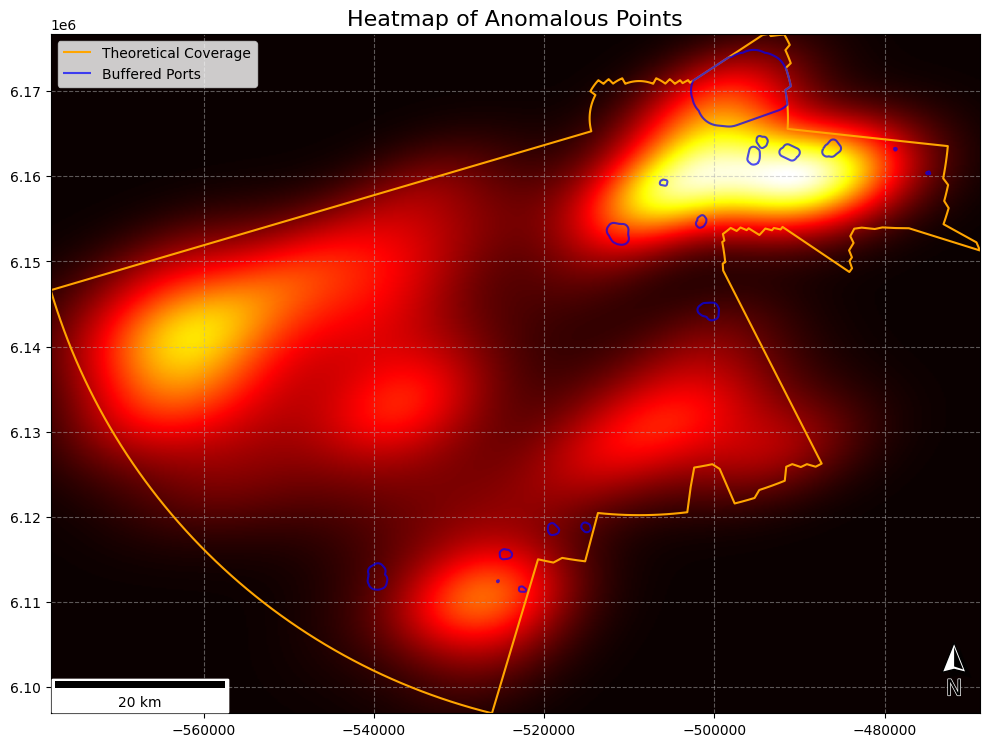

In [19]:
plot_static_heatmap()

## Temporal distribution graphs

Note, that the "analyze" mode shows the result for all vessels.

In [20]:
def plot_temporal_distribution(plot_type='timeframe', label_filter=None):
    """
    Plots the normalized temporal distribution of unusual points (filtered_df) over the original dataset (df).

    Args:
        plot_type (str): The type of plot to create: 'timeframe', 'hour', or 'weekday'.
        label_filter (str): Optional label to filter points by: 'support', 'incident', or None (for all).
    """

    #set standard font sizes
    plt.rc('font', size=18)
    plt.rc('axes', titlesize=18)
    plt.rc('axes', labelsize=18)
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    plt.rc('legend', fontsize=16)
    plt.rc('figure', titlesize=25)

    plt.figure(figsize=(10, 6))

    #filter if desired
    data = filtered_df.copy()
    if label_filter:
        data = data[data['label'] == label_filter]

    #prepare columns for both dataframes
    df['day'] = df['t'].dt.date
    df['hour'] = df['t'].dt.hour
    df['weekday'] = df['t'].dt.day_name()

    data['day'] = data['t'].dt.date
    data['hour'] = data['t'].dt.hour
    data['weekday'] = data['t'].dt.day_name()

    #choose aggregation level and normalize
    if plot_type == 'timeframe':
        num = data.groupby('day')['day'].count()
        den = df.groupby('day')['day'].count()
        result = (num / den).fillna(0)
        result.plot(kind="line", color='royalblue')
        plt.title(f"Normalized Unusual Points over Timeframe")
        plt.xlabel("Date")
    elif plot_type == 'hour':
        num = data.groupby('hour')['hour'].count()
        den = df.groupby('hour')['hour'].count()
        result = (num / den).fillna(0)
        result.plot(kind="bar", color='royalblue')
        plt.title(f"Normalized Unusual Points per Hour")
        plt.xlabel("Hour")
    elif plot_type == 'weekday':
        weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        num = data.groupby('weekday')['weekday'].count()
        den = df.groupby('weekday')['weekday'].count()
        result = (num / den).reindex(weekday_order).fillna(0)
        result.plot(kind="bar", color='royalblue')
        plt.title(f"Normalized Unusual Points per Weekday")
        plt.xlabel("Weekday")
    else:
        print("Invalid plot type. Choose from 'timeframe', 'hour', or 'weekday'.")
        return

    plt.ylabel("Proportion of Unusual Points")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    #reset font sizes
    mpl.rcdefaults()


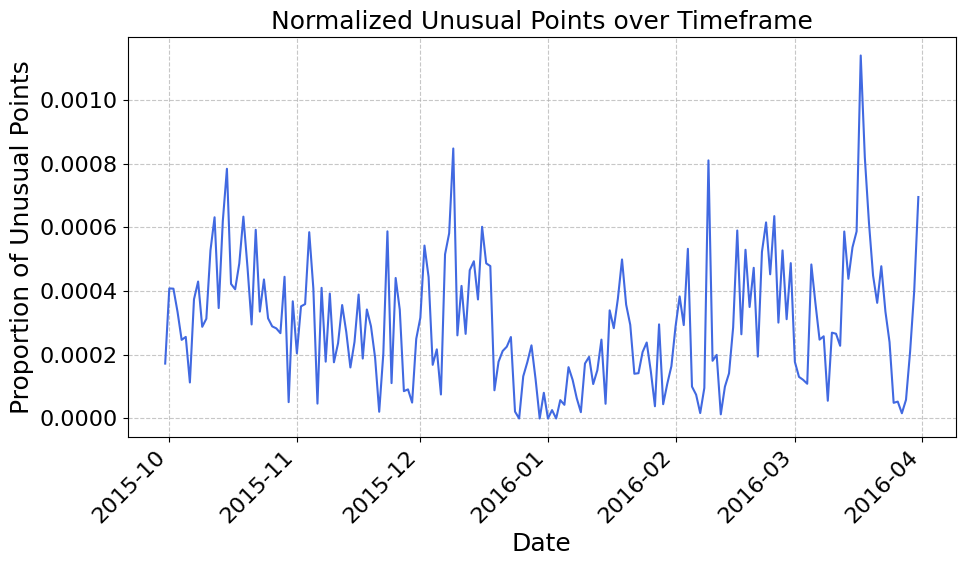

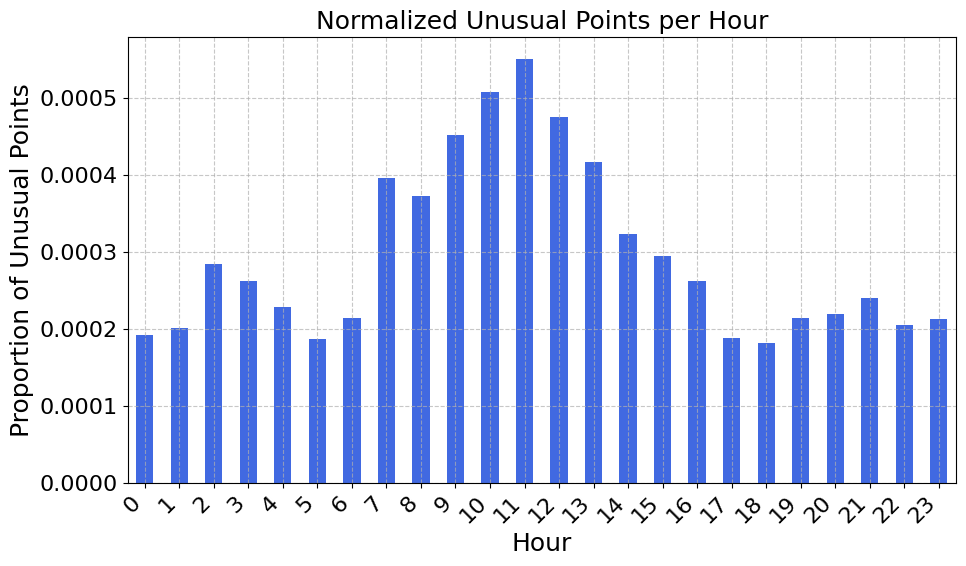

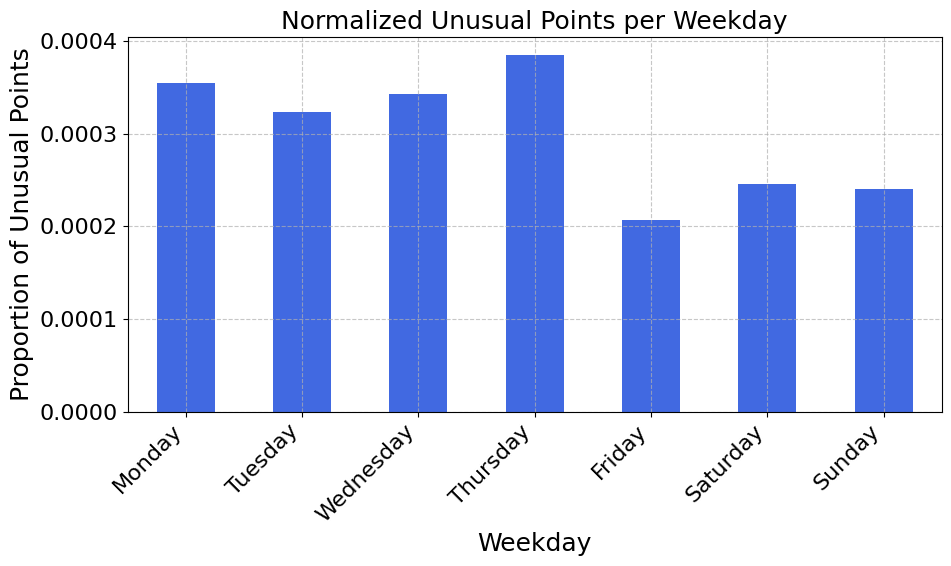

In [21]:
plot_temporal_distribution(plot_type='timeframe')  # plot for timeframe
plot_temporal_distribution(plot_type='hour')      # plot for hour
plot_temporal_distribution(plot_type='weekday')   # plot for weekday
#plot_temporal_distribution(plot_type='timeframe', label_filter='support')  # plot for timeframe with support label
#plot_temporal_distribution(plot_type='hour', label_filter='support')       # plot for hour with support label
#plot_temporal_distribution(plot_type='weekday', label_filter='support')    # plot for weekday with support label
#plot_temporal_distribution(plot_type="timeframe", label_filter='incident')  # plot for timeframe with incident label
#plot_temporal_distribution(plot_type='hour', label_filter='incident')       # plot for hour with incident label
#plot_temporal_distribution(plot_type='weekday', label_filter='incident')    # plot for weekday with incident label

## Summing the time difference by vessel

In [22]:
#sum up the total time gap per suspicious vessel
def total_time_diff():
  #group by mmsi and sum time differences
  total_time_diff_per_vessel = filtered_df.groupby('sourcemmsi')['t_diff'].sum().reset_index()

  #rename columns
  total_time_diff_per_vessel.columns = ['mmsi', 'total_time_diff']

  #return
  return total_time_diff_per_vessel

total_time_diff_per_vessel = total_time_diff()
total_time_diff_per_vessel

,mmsi,total_time_diff
0,37100300,0 days 01:07:38
1,205277430,0 days 00:39:30
2,205439000,0 days 00:40:03
3,209015000,0 days 10:22:11
4,211158080,0 days 01:31:30
...,...,...
382,565494000,100 days 04:01:50
383,577228000,0 days 00:44:40
384,577333000,0 days 00:39:29
385,888888888,10 days 18:25:32
